# Setup
---


Import python modules

In [3]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import yfinance as yf
import os
import nasdaqdatalink
import matplotlib.pyplot as plt
import tensorflow as tf
from yahoofinancials import YahooFinancials
from sklearn.base import BaseEstimator
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
from sklearn import metrics
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from dotenv import load_dotenv

Configure environment and API key. The key content is left out for security

In [4]:
load_dotenv()

True

Some global variables

In [3]:
## The foreign currency
ccy = 'CAD'

## The inflation dataset
inf_dataset = 'RATEINF/INFLATION_CAN'

## Comparison matrix
compare = pd.DataFrame({'item': ['Goal','Model','R2-Test', 'Mean Absolute Error','Mean Squared Error','Root Mean Squared Error']})
compare.set_index('item')

""
item
Goal
Model
R2-Test
Mean Absolute Error
Mean Squared Error
Root Mean Squared Error


# Data exploration
---

Downloads data sets and explore the data.

The exchange rate history is going to be our main dataset. 

Besides, certain economic indicators which are often regarded to influence exchange rates are obtained. Including: 

- FED fund rates
- Inflation rates (year on year) of both countries


In [4]:
fed_rates = nasdaqdatalink.get("FED/RIFSPFF_N_D")
fed_rates = fed_rates['2004-01-01':]
print(fed_rates.head())
fed_rates.describe()

            Value
Date             
2004-01-01   0.94
2004-01-02   1.01
2004-01-03   1.01
2004-01-04   1.01
2004-01-05   0.97


,Value
count,7204.000000
mean,1.442708
std,1.727701
min,0.040000
25%,0.120000
50%,0.400000
75%,2.330000
max,5.410000


In [5]:
fccy_inflation_rate = nasdaqdatalink.get(inf_dataset)
fccy_inflation_rate = fccy_inflation_rate['2003-11-30':]
print(fccy_inflation_rate.head())
fccy_inflation_rate.describe()

            Value
Date             
2003-11-30    1.6
2003-12-31    2.1
2004-01-31    1.3
2004-02-29    0.7
2004-03-31    0.8


,Value
count,238.000000
mean,2.133613
std,1.481861
min,-0.900000
25%,1.300000
50%,2.000000
75%,2.400000
max,8.100000


In [6]:
usa_inflation_rate = nasdaqdatalink.get("RATEINF/INFLATION_USA")
usa_inflation_rate = usa_inflation_rate['2003-11-30':]
print(usa_inflation_rate.head())
usa_inflation_rate.describe()

            Value
Date             
2003-11-30  1.765
2003-12-31  1.879
2004-01-31  1.926
2004-02-29  1.693
2004-03-31  1.737


,Value
count,238.000000
mean,2.553702
std,1.950578
min,-2.097000
25%,1.479500
50%,2.135000
75%,3.410500
max,9.060000


In [7]:
ticker = yf.Ticker(ccy+ '=X')
hist = ticker.history(period='max')
hist = hist['2004-01-01':]
hist.rename(columns={'Close':'close', 'Open':'open', 'High':'high', 'Low':'low', 'Volume':'volume'}, inplace=True)
hist.drop(columns=['Dividends', 'Stock Splits'], inplace=True)
hist


,open,high,low,close,volume
Date,,,,,
2004-01-01 00:00:00+00:00,1.29720,1.29720,1.28130,1.29600,0
2004-01-02 00:00:00+00:00,1.29430,1.29800,1.28620,1.29250,0
2004-01-05 00:00:00+00:00,1.28650,1.28890,1.27730,1.28120,0
2004-01-06 00:00:00+00:00,1.28080,1.28720,1.27660,1.28660,0
2004-01-07 00:00:00+00:00,1.28680,1.29220,1.28410,1.28950,0
...,...,...,...,...,...
2023-09-18 00:00:00+01:00,1.35219,1.35270,1.34718,1.35219,0
2023-09-19 00:00:00+01:00,1.34870,1.34876,1.33876,1.34870,0
2023-09-20 00:00:00+01:00,1.34427,1.34641,1.33955,1.34427,0


<Figure size 640x480 with 0 Axes>

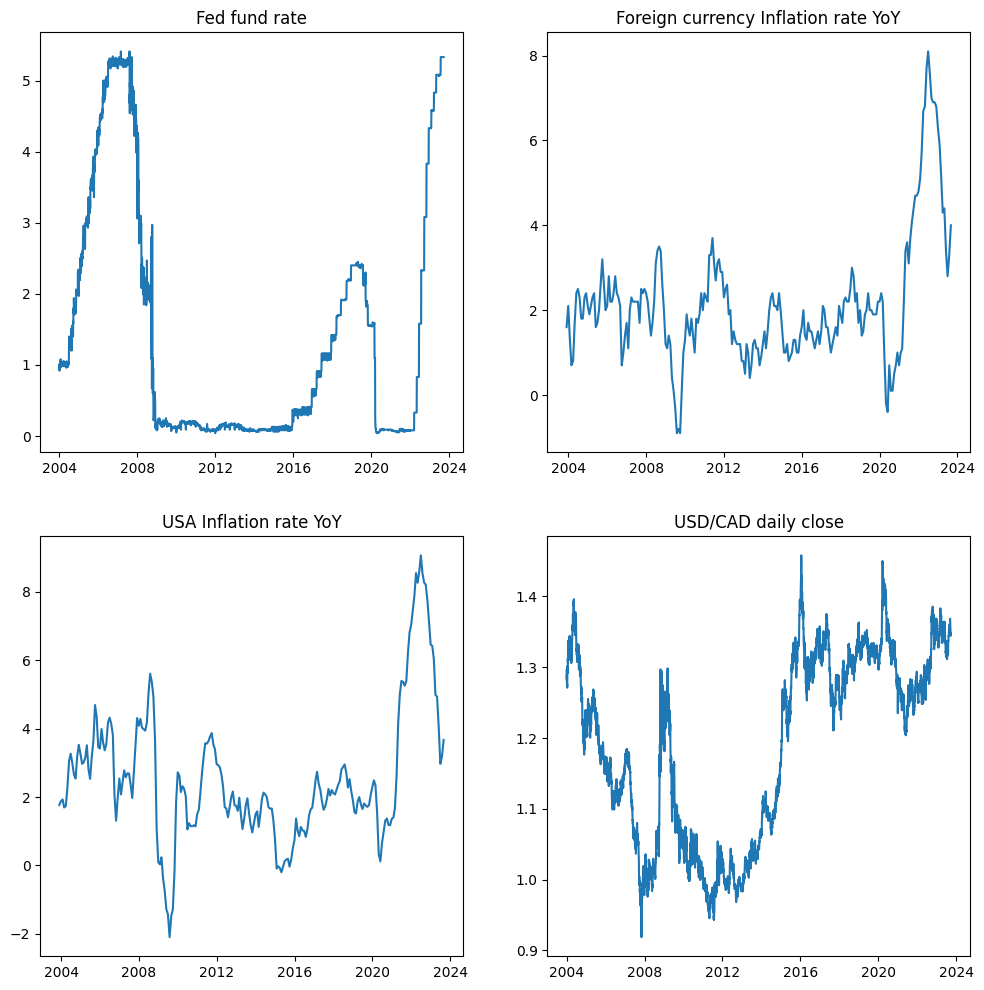

In [8]:
plt.figure(1)
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(12,12))
ax1.plot(fed_rates)
ax1.title.set_text('Fed fund rate')
ax2.plot(fccy_inflation_rate)
ax2.title.set_text('Foreign currency Inflation rate YoY')
ax3.plot(usa_inflation_rate)
ax3.title.set_text('USA Inflation rate YoY')
ax4.plot(hist['close'])
ax4.title.set_text('USD/' + ccy + ' daily close')
plt.show()

In [9]:
## Combine the data

hist.index = hist.index.date

combined = hist \
    .merge(fed_rates, how='outer', left_index=True, right_index=True, suffixes=(None, "_fed")) \
    .merge(usa_inflation_rate, how='outer', left_index=True, right_index=True, suffixes=(None, "_usa_inf")) \
    .merge(fccy_inflation_rate, how='outer', left_index=True, right_index=True, suffixes=(None, "_fccy_inf"))


# Data cleansing
---

Handle NA values in the dataset. 

Forward fill is used as the most meaningful value in time series (and financial market) is the "past observation"

In [10]:
combined.rename(columns={'Value':'fed_rate', 'Value_usa_inf':'usa_inf','Value_fccy_inf':'fccy_inf'}, inplace=True)
# forward-fill fields with no data
combined['fed_rate'].fillna(method='ffill', inplace=True)
combined['usa_inf'].fillna(method='ffill', inplace=True)
combined['fccy_inf'].fillna(method='ffill', inplace=True)
combined['relative_inf'] = combined['usa_inf']/combined['fccy_inf']



In [11]:
# Drop NA rows. This usually include the first few rows
df=combined.copy().dropna()
df

,open,high,low,close,volume,fed_rate,usa_inf,fccy_inf,relative_inf
2004-01-01,1.29720,1.29720,1.28130,1.29600,0.0,0.94,1.879,2.1,0.894762
2004-01-02,1.29430,1.29800,1.28620,1.29250,0.0,1.01,1.879,2.1,0.894762
2004-01-05,1.28650,1.28890,1.27730,1.28120,0.0,0.97,1.879,2.1,0.894762
2004-01-06,1.28080,1.28720,1.27660,1.28660,0.0,0.92,1.879,2.1,0.894762
2004-01-07,1.28680,1.29220,1.28410,1.28950,0.0,0.94,1.879,2.1,0.894762
...,...,...,...,...,...,...,...,...,...
2023-09-18,1.35219,1.35270,1.34718,1.35219,0.0,5.33,3.665,4.0,0.916250
2023-09-19,1.34870,1.34876,1.33876,1.34870,0.0,5.33,3.665,4.0,0.916250
2023-09-20,1.34427,1.34641,1.33955,1.34427,0.0,5.33,3.665,4.0,0.916250
2023-09-21,1.34767,1.35222,1.34700,1.34767,0.0,5.33,3.665,4.0,0.916250


# Feature extraction
---

- Technical indicators: 4 categories of technical indicators are included in the data set. They are often used by industry experts to predict stock/forex prices.

In [12]:
df.ta.strategy('momentum', append=True)
df.ta.strategy('trend', append=True)
df.ta.strategy('volatility', append=True)
df.ta.strategy('candles', append=True)

0it [00:00, ?it/s]

39it [00:02, 15.31it/s]
14it [00:01,  7.59it/s]
14it [00:01, 11.67it/s]
3it [00:01,  1.71it/s]


- Percentage change: the change in price compared with last 1 day and last 5 days

In [13]:
df['1d_delta'] = df['close'].pct_change(1)
df['5d_delta'] = df['close'].pct_change(5)



- remove columns with all NA values; fill NAs with forward fill; and drop NA rows (that corresponds to the first few rows which cannot be filled)

In [14]:
df = df.dropna(axis='columns', how='all').fillna(method='ffill').dropna()


- By shifting 1d_delta, I create `1d_future` which is going to be the Y values to be trained against

In [15]:
# the answer to be trained
df['1d_future'] = df['1d_delta'].shift(-1)
df.dropna(inplace=True)

- Standardize the data

In [16]:
## apply scaling
scaler = StandardScaler();
data = scaler.fit_transform(df)
data = pd.DataFrame(data, index=df.index, columns = df.columns)
data

,open,high,low,close,volume,fed_rate,usa_inf,fccy_inf,relative_inf,AO_5_34,...,high_Z_30_1,low_Z_30_1,close_Z_30_1,HA_open,HA_high,HA_low,HA_close,1d_delta,5d_delta,1d_future
2004-05-19,1.543178,1.514431,1.451512,1.433144,0.0,-0.258146,-0.144331,-0.303018,0.086625,1.806160,...,0.797264,0.589183,0.439357,1.553370,1.507727,1.461720,1.485911,-1.886636,-0.639317,-1.020127
2004-05-20,1.433782,1.435557,1.391425,1.373881,0.0,-0.258146,-0.144331,-0.303018,0.086625,1.495262,...,0.394265,0.274537,0.116049,1.519942,1.474395,1.401548,1.408982,-1.019380,-1.460648,0.352373
2004-05-21,1.372246,1.409013,1.391425,1.394395,0.0,-0.263883,-0.144331,-0.303018,0.086625,1.180075,...,0.219348,0.234339,0.176283,1.464745,1.419356,1.401548,1.392077,0.352635,-0.965526,-0.067545
2004-05-24,1.399595,1.402187,1.382298,1.390596,0.0,-0.258146,-0.144331,-0.303018,0.086625,0.896442,...,0.140204,0.140817,0.105314,1.428689,1.393120,1.392408,1.393977,-0.067135,-1.464044,0.024170
2004-05-25,1.388200,1.406739,1.377734,1.392116,0.0,-0.258146,-0.144331,-0.303018,0.086625,0.536888,...,0.120532,0.065069,0.064861,1.411612,1.397668,1.387839,1.391508,0.024548,-1.166867,-0.067559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-15,1.244466,1.234961,1.262123,1.245324,0.0,2.225588,0.556297,1.239509,-0.201909,0.231806,...,-0.167998,-0.127522,-0.169018,1.278023,1.233170,1.272064,1.246978,-0.501162,-1.000930,0.092323
2023-09-18,1.249860,1.218655,1.245998,1.250719,0.0,2.225588,0.556297,1.239509,-0.201909,0.078066,...,-0.469574,-0.408999,-0.162415,1.262743,1.217933,1.255916,1.241564,0.092676,-0.627546,-0.465657
2023-09-19,1.223346,1.188774,1.181955,1.224202,0.0,2.225588,0.556297,1.239509,-0.201909,-0.088928,...,-0.890411,-1.355535,-0.622488,1.252394,1.207614,1.191783,1.204828,-0.465107,-0.549941,-0.592062
2023-09-20,1.189692,1.170951,1.187964,1.190543,0.0,2.225588,0.556297,1.239509,-0.201909,-0.235014,...,-1.160121,-1.256201,-1.153070,1.228843,1.184131,1.197801,1.185036,-0.591467,-0.650150,0.452271


In [17]:
features = np.array(data.columns).tolist()
features.remove('1d_future')
features

['open',
 'high',
 'low',
 'close',
 'volume',
 'fed_rate',
 'usa_inf',
 'fccy_inf',
 'relative_inf',
 'AO_5_34',
 'APO_12_26',
 'BIAS_SMA_26',
 'BOP',
 'AR_26',
 'BR_26',
 'CCI_14_0.015',
 'CFO_9',
 'CG_10',
 'CMO_14',
 'COPC_11_14_10',
 'CTI_12',
 'ER_10',
 'BULLP_13',
 'BEARP_13',
 'FISHERT_9_1',
 'FISHERTs_9_1',
 'INERTIA_20_14',
 'K_9_3',
 'D_9_3',
 'J_9_3',
 'KST_10_15_20_30_10_10_10_15',
 'KSTs_9',
 'MACD_12_26_9',
 'MACDh_12_26_9',
 'MACDs_12_26_9',
 'MOM_10',
 'PGO_14',
 'PPO_12_26_9',
 'PPOh_12_26_9',
 'PPOs_12_26_9',
 'PSL_12',
 'QQE_14_5_4.236',
 'QQE_14_5_4.236_RSIMA',
 'QQEl_14_5_4.236',
 'QQEs_14_5_4.236',
 'ROC_10',
 'RSI_14',
 'RSX_14',
 'RVGI_14_4',
 'RVGIs_14_4',
 'SLOPE_1',
 'SMI_5_20_5',
 'SMIs_5_20_5',
 'SMIo_5_20_5',
 'SQZ_20_2.0_20_1.5',
 'SQZ_ON',
 'SQZ_OFF',
 'SQZ_NO',
 'SQZPRO_20_2.0_20_2_1.5_1',
 'SQZPRO_ON_WIDE',
 'SQZPRO_ON_NORMAL',
 'SQZPRO_ON_NARROW',
 'SQZPRO_OFF',
 'SQZPRO_NO',
 'STC_10_12_26_0.5',
 'STCmacd_10_12_26_0.5',
 'STCstoch_10_12_26_0.5',
 'S

# Simple Demonstration - Why predicting absolute price is not useful

In [18]:
y_test_price = df['close'] * (1+df['1d_future'])
y_pred_price = df['close']

R2 on Test Set:  0.9975030632379344
Mean Absolute Error: 0.0047490758780288625
Mean Squared Error: 4.324853988585627e-05
Root Mean Squared Error: 0.00657636220762332


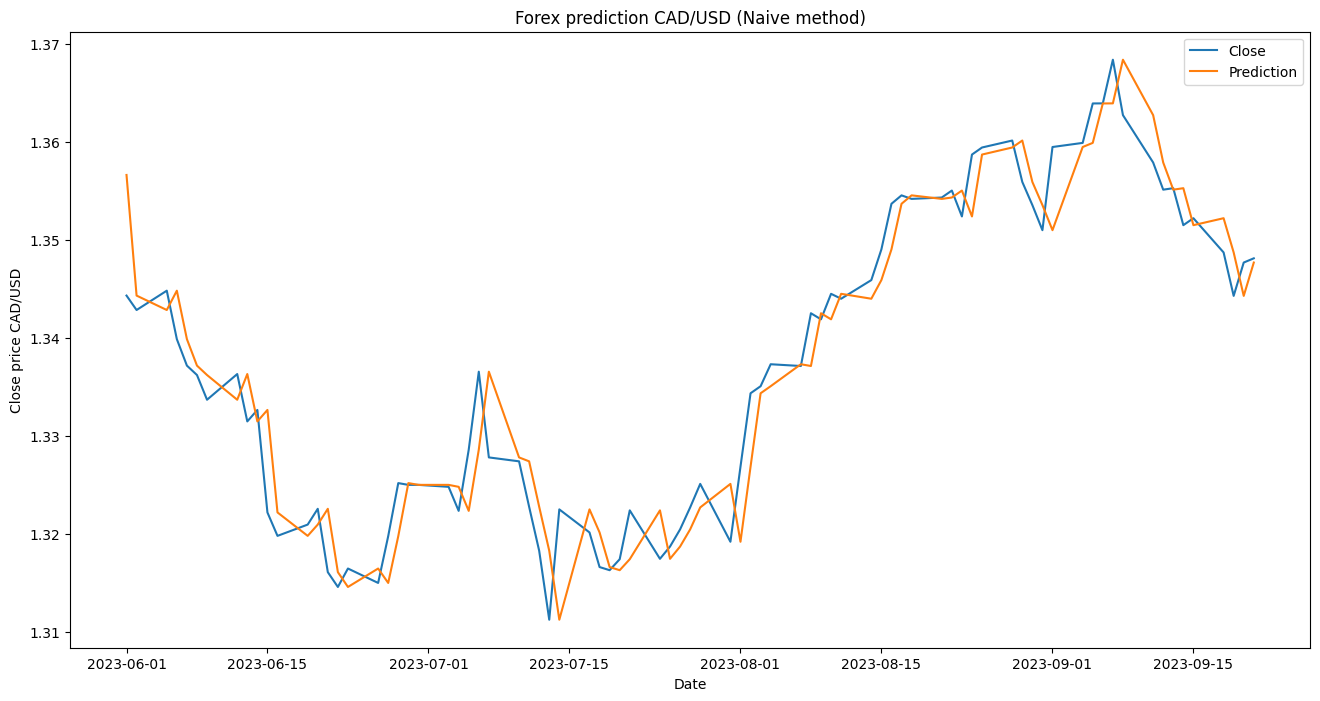

In [19]:
print('R2 on Test Set: ',  metrics.r2_score(y_test_price, y_pred_price))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_price, y_pred_price))
print('Mean Squared Error:', metrics.mean_squared_error(y_test_price, y_pred_price))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_price, y_pred_price)))
plt.figure(figsize=(16,8))
plt.title("Forex prediction CAD/USD (Naive method)")
plt.xlabel("Date")
plt.ylabel("Close price "+ccy+"/USD")
plt.plot(y_test_price['2023-06-01':])
plt.plot(y_pred_price['2023-06-01':])
plt.legend(['Close', 'Prediction'])
plt.show()

- As demonstrated in the above code, just by assuming the next day price is going to be unchanged, we achieve a nearly perfect R2 score of 0.9975.
- It is because for time series data, the current price is highly coorelated to T+1 price. It is especially true for forex markets since the fluctuations in price is relatively small
- What we are interested at is the **change** in price

# Random forest on 1d price change
---

Prepare the training and testing data for RF

In [20]:
# split data
x = data[features]
y = data['1d_future']


# In time series prediction, we are always faced with predicting the future instead of interpolating values
# Hence instead of randomly picking train/test data, we split it with a specific cutoff time
train_size = int(0.7 * y.shape[0])
x_train = x[:train_size]
y_train = y[:train_size]
x_test = x[train_size:]
y_test = y[train_size:]

## Hyper-Parameter tuning

Prior to using Grid search, I explore using different values of hyperparameters, one at a time, and plot train/test R2 scores. 

It is to look for a reasonble range to feed in Grid Search for every hyperparameter.

Reference: https://www.analyticsvidhya.com/blog/2020/03/beginners-guide-random-forest-hyperparameter-tuning/

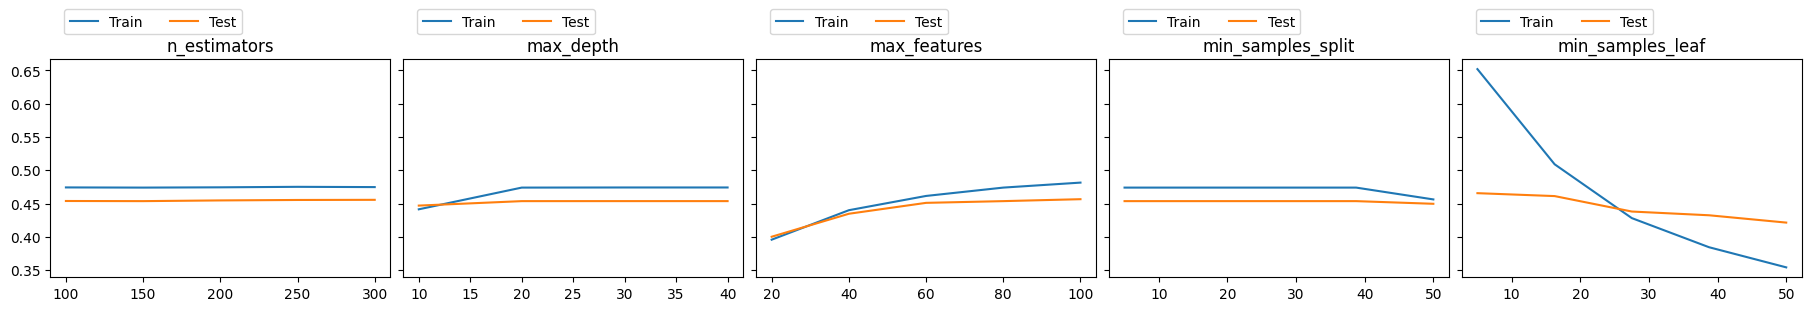

In [21]:


fig, axs = plt.subplots(ncols=5, figsize=(18,3), sharey=True, sharex=False, layout='constrained')
hyperparams = {
    'n_estimators': np.linspace(100, 300, 5),
    'max_depth': np.linspace(10,40,4),
    'max_features':np.linspace(20,100, 5),
    'min_samples_split' : np.linspace(5,50,5),
    'min_samples_leaf' : np.linspace(5,50,5)
}
i=0
for key, value in hyperparams.items():    
    train_score = []
    test_score = []
    for num in value:
         rf_model = RandomForestRegressor(n_estimators=150, max_depth=20, max_features=80, min_samples_split=20,  min_samples_leaf=20, random_state=42,)
         params = {key: int(num)}
         rf_model.set_params(**params)
         rf_model.fit(x_train, y_train)
         y_pred = rf_model.predict(x_test)
         train_score.append(rf_model.score(x_train, y_train))
         test_score.append(metrics.r2_score(y_test, y_pred))    
    
    axs[i].set_title(key)
    axs[i].plot(value, np.array(train_score), label='Train')
    axs[i].plot(value, np.array(test_score), label='Test')
    axs[i].legend(loc='lower left', bbox_to_anchor=(0,1.05), ncols=2, borderaxespad=1)
    i = i+1
plt.show()


Interpretations: 

- Apparently within the search range, `n_estimators`, `min_sample_split` and `max_depth` does not really affect the model accuracy
- `max_features` above 60 does not contribute much to accuracy
- With training R2 much higher than testing R2, a low `min_samples_leaf` could cause overfitting. 20 seems to be a good number.

**Perform Grid Search**

Find the best set of hyperparameters, reduce overfitting by using k-fold cross validation 

In [22]:
grid = {'n_estimators':[150], 'max_depth': [15, 20, 25], 'max_features': [40,60,80], 'min_samples_split': [10,20,30], 'min_samples_leaf': [20], 'random_state': [42]}
test_scores = []

rf_model = RandomForestRegressor()
grid_search = GridSearchCV(estimator=rf_model, param_grid=grid, scoring='r2', cv=5)
grid_search.fit(x_train, y_train)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_


print("Best parameters: ", best_params)


Best parameters:  {'max_depth': 15, 'max_features': 80, 'min_samples_leaf': 20, 'min_samples_split': 10, 'n_estimators': 150, 'random_state': 42}


## Predict and score

With the best model, predict y values and evaluate

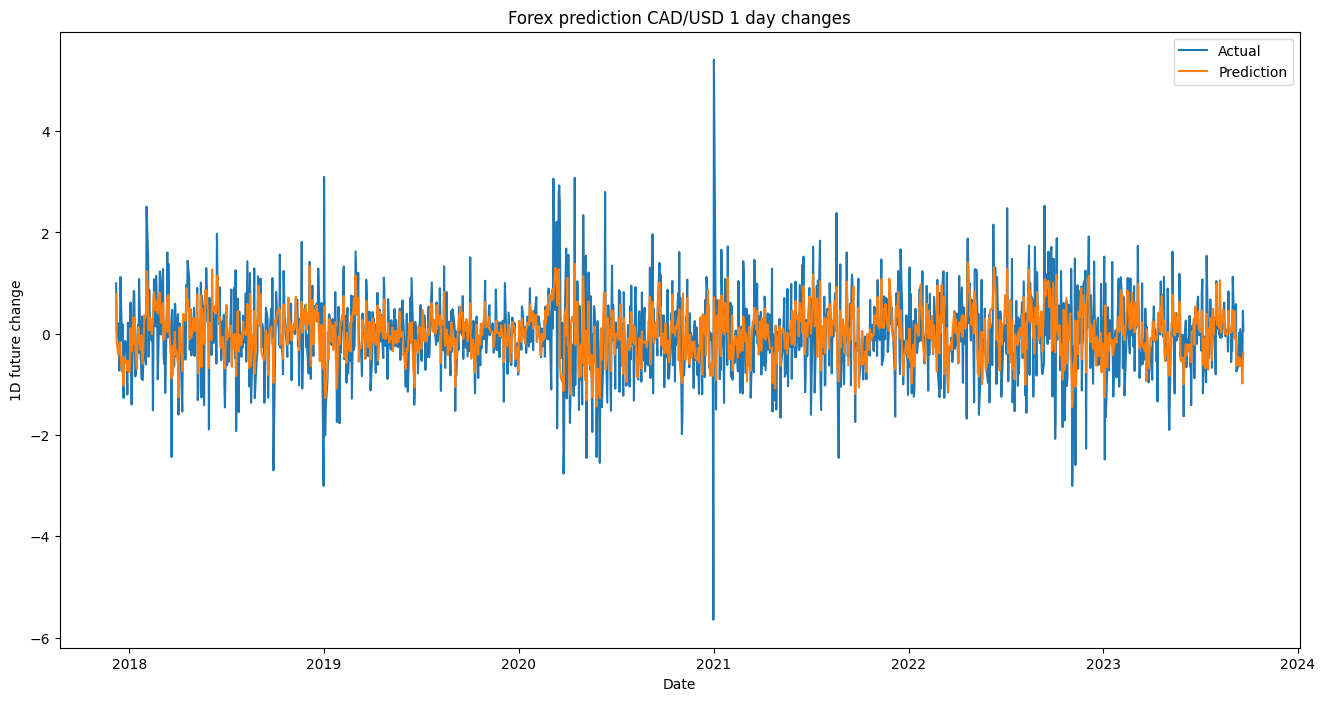

R2 on Training Set:  0.47147822767186687

R2 on Test Set:  0.45328564048637854
Mean Absolute Error: 0.43212614419989437
Mean Squared Error: 0.35541815743447114
Root Mean Squared Error: 0.5961695710403804


In [23]:
best_model.fit(x_train, y_train)
y_pred = best_model.predict(x_test)
y_pred_series = pd.Series(y_pred, index= y_test.index)
y_test_series = pd.Series(y_test, index= y_test.index)

plt.figure(figsize=(16,8))
plt.title("Forex prediction " + ccy + "/USD 1 day changes")
plt.xlabel("Date")
plt.ylabel("1D future change")
plt.plot(y_test_series)
plt.plot(y_pred_series)
plt.legend(['Actual', 'Prediction'])

plt.show()
print('R2 on Training Set: ', best_model.score(x_train, y_train))
print()
print('R2 on Test Set: ',  metrics.r2_score(y_test, y_pred))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
compare['RF-PD-CHNG'] = ['Next Day Price change', 'Random Forest', metrics.r2_score(y_test, y_pred) ,metrics.mean_absolute_error(y_test, y_pred),metrics.mean_squared_error(y_test, y_pred),np.sqrt(metrics.mean_squared_error(y_test, y_pred))]


In [24]:
feat_imprt = pd.DataFrame(best_model.feature_importances_, columns=['Importance'])
feat_imprt['feat'] = np.array(features)
print('Top 20 important features')
feat_imprt.sort_values(by='Importance', ascending=False)[:20]

Top 20 important features


,Importance,feat
90,0.326148,DPO_20
22,0.063028,BULLP_13
23,0.037793,BEARP_13
155,0.036657,CDL_GRAVESTONEDOJI
125,0.033106,PDIST
150,0.031638,CDL_DRAGONFLYDOJI
131,0.022555,TRUERANGE_1
188,0.020247,CDL_TAKURI
15,0.018723,CCI_14_0.015
78,0.014993,DMP_14


## Interpretations
- With an R2 Test of 0.45, Random Forest is not regarded very useful in change predictions
- R2 Test & R2 Train is quite close (0.45 vs 0.47). This shows that problem of overfitting has been well addressed by GridSearch cross validation
- Could nevertheless serve as a baseline for evaluations of other models.
- The plot above do indicate that the model could capture some up and down trends
- Feature analysis shows that a range of technical indicators such as DPO and BULL/BEAR contributed a lot to the prediction.

# LSTM on 1d price change
---

## Setup

In [25]:
## Setup
time_steps = 10
train_percentage = 0.8

## Workaround suggested in https://github.com/scikit-optimize/scikit-optimize/issues/1138
np.int = int

## Define a wrapper class for parameter tuning
class BaseLSTMModel(BaseEstimator):
    def __init__(self, units_layer1=50, units_layer2=0, dropout_rate=0.2, batch_size = 32, activation='relu', epoch=25, validation_split=0, verbose=0):
        self.units_layer1 = units_layer1
        self.units_layer2 = units_layer2
        self.dropout_rate = dropout_rate
        self.batch_size = batch_size
        self.activation = activation
        self.validation_split = validation_split
        self.epoch = epoch
        self.verbose = verbose
    
    def fit(self, X, y):       
        self.model = Sequential()
        if (self.units_layer2 > 0):
            self.model.add(LSTM(self.units_layer1, self.activation, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
            self.model.add(LSTM(self.units_layer2, self.activation, return_sequences=False))
        else:
            self.model.add(LSTM(self.units_layer1, self.activation, input_shape=(X.shape[1], X.shape[2]), return_sequences=False))
        ##self.model.add(Dense(1)) with 32 or 64
        self.model.add(Dropout(self.dropout_rate))
        self.model.add(Dense(1))
        self.model.compile(loss='mean_squared_error', optimizer='adam') 
        return self.model.fit(X, y, epochs=self.epoch, batch_size=self.batch_size, verbose=self.verbose, shuffle=False, validation_split=self.validation_split)
        

    def predict(self, X):
        return self.model.predict(X)
    
    def summary(self):
        self.model.summary()

In [42]:
features_for_price_change = np.array(feat_imprt.sort_values(by='Importance', ascending=False)[:50]['feat']).tolist()

In [43]:
## Reshape input data into n samples of sequences
## Each has a X value corresponding to the past 10 days of data with 20 features
## and a Y value corresponding to the next day closing price


print('Shape of data: ', data.shape)
train_size = int(train_percentage * data.shape[0])
train_data = data[:train_size]
train_data_features = train_data[features_for_price_change].values
train_delta = train_data[['1d_future']].values

x = []
y = []
for i in range(time_steps, len(train_data_features)):
    x.append(train_data_features[i - time_steps: i, 0:train_data_features.shape[1]])
    y.append(train_delta[i-1:i, 0])

x_train, y_train = np.array(x), np.array(y)

print('Shape of x_train', x_train.shape)
print('Shape of y_train', y_train.shape)


test_data = data[train_size:]
test_data_features = test_data[features_for_price_change].values
test_delta = test_data[['1d_future']].values
x_test = []
y_test = []
for i in range(time_steps, len(test_data_features)):
    x_test.append(test_data_features[i - time_steps: i, 0: test_data_features.shape[1]])
    y_test.append(test_delta[i-1:i, 0])

x_test, y_test = np.array(x_test), np.array(y_test)
print('Shape of x_test', x_test.shape)
print('Shape of y_test', y_test.shape)

Shape of data:  (5033, 206)
Shape of x_train (4016, 10, 50)
Shape of y_train (4016, 1)
Shape of x_test (997, 10, 50)
Shape of y_test (997, 1)


## Model tuning

In [58]:
## Caution: This runs a LONG time

## Model tuning using Bayesian Search
## Due to the large parameter space and computational resource constraint, the search itself is an iterative process. 
## By examining the output score I can refine the range for each variable to search.
lstm_model = BaseLSTMModel()
param_space = {
    'units_layer1' : Integer(16, 128, prior='log-uniform'),
    'dropout_rate' : Real(0.1, 0.5, prior='uniform'),
    'batch_size' : Integer(8, 32, prior='log-uniform'),
    'epoch' : Integer(10,30, prior='log-uniform'),
    'activation' : ['sigmoid']
}

tscv = TimeSeriesSplit(n_splits=5)
opt = BayesSearchCV(estimator=lstm_model, search_spaces=param_space, cv=tscv, n_iter=30, n_jobs=-1, scoring='neg_mean_squared_error', verbose=0, random_state=42 )
opt.fit(x_train, y_train)

print('Best hyperparameters:' , opt.best_params_)
print('Best negative MSE: ', opt.best_score_)
opt.best_estimator_

21/21 [==============================] - 0s 2ms/step
Best hyperparameters: OrderedDict([('activation', 'sigmoid'), ('batch_size', 21), ('dropout_rate', 0.1), ('epoch', 18), ('units_layer1', 128)])
Best negative MSE:  -0.7709982864675091


BaseLSTMModel(activation='sigmoid', batch_size=21, dropout_rate=0.1, epoch=18,
              units_layer1=128)

## Examine Loss Plot

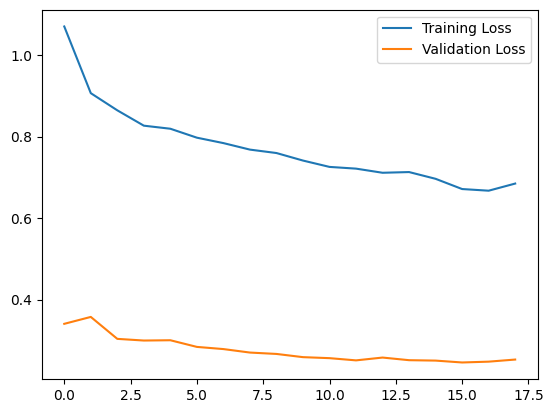

In [59]:
lstm = BaseLSTMModel(**opt.best_params_, validation_split=0.2)
history = lstm.fit(x_train, y_train)
plt.plot(history.history.get('loss'), label='Training Loss')
plt.plot(history.history.get('val_loss'), label='Validation Loss')
plt.legend()


In [60]:
## Re-fit with the full training set. Make prediction and scoring

lstm = BaseLSTMModel(**opt.best_params_)
history = lstm.fit(x_train, y_train)
predictions = lstm.predict(x_test)
print('R2 on Test Set: ',  metrics.r2_score(y_test, predictions))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

compare['LSTM-PD-CHNG'] = ['Next Day Price change', 'Long Short Term Memory', metrics.r2_score(y_test, predictions) ,metrics.mean_absolute_error(y_test, predictions),metrics.mean_squared_error(y_test, predictions),np.sqrt(metrics.mean_squared_error(y_test, predictions))]

32/32 [==============================] - 1s 16ms/step
R2 on Test Set:  0.5874142457752161
Mean Absolute Error: 0.3942941936235917
Mean Squared Error: 0.2996494106992676
Root Mean Squared Error: 0.5474024211667935


**Best result**

Due to the random nature of hyperparameter search, the best result may not be replicated every time a parameter is changed. 
This is a copy of some of the best result ever achieved

>```
>Best hyperparameters: OrderedDict([('activation', 'sigmoid'), ('batch_size', 21), ('dropout_rate', 0.1), ('epoch', 18), ('units_layer1', 128)])
>R2 on Test Set:  0.5874142457752161
>Mean Absolute Error: 0.3942941936235917
>Mean Squared Error: 0.2996494106992676
>Root Mean Squared Error: 0.5474024211667935
>```

>
> ```
> Best hyperparameters: OrderedDict([('activation', 'sigmoid'), ('batch_size', 8), ('dropout_rate', 0.313842456579153), ('epoch', 10), ('units_layer1', 31)])
> R2 on Test Set:  0.5322472091735166
> Mean Absolute Error: 0.425410687922783
> Mean Squared Error: 0.3397156753205077
> Root Mean Squared Error: 0.5828513320912184
> ```

In [61]:
## Inverse transform the predictions to get predicted value of 1d_future
index_1d_future = test_data.columns.get_loc('1d_future')
result = scaler.inverse_transform(test_data)
result = pd.DataFrame(result, index=test_data.index, columns = test_data.columns)
inverse_scaler = StandardScaler()
inverse_scaler.mean_=[scaler.mean_[index_1d_future]]
inverse_scaler.scale_=[scaler.scale_[index_1d_future]]
predicted_changes = inverse_scaler.inverse_transform(predictions)
result = result[time_steps:].copy()
result['Prediction'] = predicted_changes


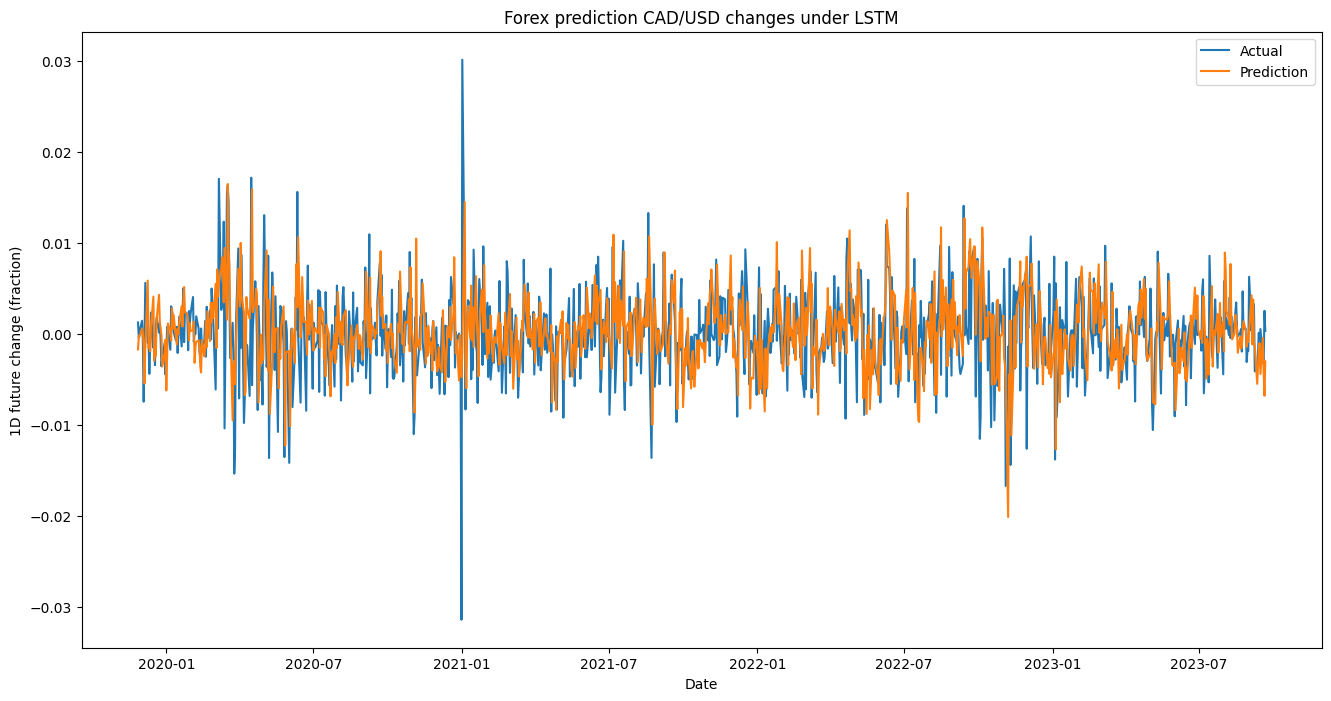

In [62]:
plt.figure(figsize=(16,8))
plt.title("Forex prediction "+ ccy + "/USD changes under LSTM")
plt.xlabel("Date")
plt.ylabel("1D future change (fraction)")
plt.plot(result['1d_future'])
plt.plot(result['Prediction'])
plt.legend(['Actual', 'Prediction'])
plt.show()

# Overall evaluation

In [63]:
compare

,item,RF-PD-CHNG,LSTM-PD-CHNG
0,Goal,Next Day Price change,Next Day Price change
1,Model,Random Forest,Long Short Term Memory
2,R2-Test,0.453286,0.587414
3,Mean Absolute Error,0.432126,0.394294
4,Mean Squared Error,0.355418,0.299649
5,Root Mean Squared Error,0.59617,0.547402
